<a href="https://colab.research.google.com/github/swilsonmfc/timeseries/blob/master/FBProphetIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facebook Prophet

![](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

## Forecasting at Scale
* https://peerj.com/preprints/3190/

## Features
* Interfaces for both Python & R
  * Automated forecasting with tuning
  * Bayesian approach
* Trend Model
  * Non-linear, Saturating Growth
  * Piece-wise Linear Model
  * Automatic changepoint selection
  * Uncertainty forecast
* Multiple seasonalities
  * Yearly, weekly, daily
  * Additive & multiplicative with dampening
  * Holiday effects
* Support for Analysts
  * Carrying capacity / floors 
  * Knowledge of changepoints
  * Holidays & Seasonality
  * Smoothing parameters (Past influence)

# Install

In [47]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.4 MB/s 
     |████████████████████████████████| 9.8 MB 38.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Setup

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

from google.colab import files

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot 
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_yearly

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Data

## Kaggle

In [2]:
if not os.path.exists('~/.kaggle/kaggle.json'):
  file = files.upload()
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d AnalyzeBoston/crimes-in-boston -p ./boston-crimes
!unzip -o ./boston-crimes/crimes-in-boston.zip -d ./boston-crimes

 67% 7.00M/10.5M [00:00<00:00, 22.9MB/s]
100% 10.5M/10.5M [00:00<00:00, 30.9MB/s]
Archive:  ./boston-crimes/crimes-in-boston.zip
  inflating: ./boston-crimes/crime.csv  
  inflating: ./boston-crimes/offense_codes.csv  


In [4]:
df = pd.read_csv('./boston-crimes/crime.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [6]:
df.dtypes

INCIDENT_NUMBER         object
OFFENSE_CODE             int64
OFFENSE_CODE_GROUP      object
OFFENSE_DESCRIPTION     object
DISTRICT                object
REPORTING_AREA          object
SHOOTING                object
OCCURRED_ON_DATE        object
YEAR                     int64
MONTH                    int64
DAY_OF_WEEK             object
HOUR                     int64
UCR_PART                object
STREET                  object
Lat                    float64
Long                   float64
Location                object
dtype: object

## Cleaning

In [7]:
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE'])
df.index = df['OCCURRED_ON_DATE']
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
OCCURRED_ON_DATE,,,,,,,,,,,,,,,,,
2018-09-02 13:00:00,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
2018-08-21 00:00:00,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2018-09-03 19:27:00,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
2018-09-03 21:16:00,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
2018-09-03 21:05:00,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [8]:
crime_df = df[['INCIDENT_NUMBER']].resample(rule='H').count()
crime_df.columns=['Count']
crime_df.head()

,Count
OCCURRED_ON_DATE,
2015-06-15 00:00:00,14
2015-06-15 01:00:00,10
2015-06-15 02:00:00,7
2015-06-15 03:00:00,3
2015-06-15 04:00:00,1


Text(0.5, 1.0, 'Boston Total Crimes by Day')

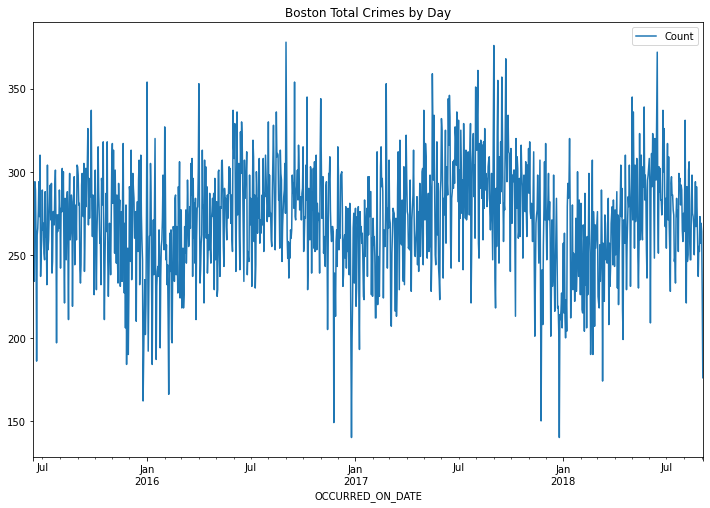

In [9]:
crime_df.resample(rule='D').sum().plot(figsize=(12,8));
plt.title('Boston Total Crimes by Day')

# Hello Prophet

In [10]:
p_df = crime_df.resample(rule='D').sum()
p_df['ds'] = p_df.index
p_df = p_df.rename(columns={'Count':'y'})
p_df.head()

,y,ds
OCCURRED_ON_DATE,,
2015-06-15,249,2015-06-15
2015-06-16,249,2015-06-16
2015-06-17,234,2015-06-17
2015-06-18,294,2015-06-18
2015-06-19,289,2015-06-19


In [12]:
model = Prophet()
model.fit(p_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecast
* To forecast, make a data frame of the future points
* Run predict on the future data frame
* Returned information includes prediction intervals and point estimates

In [13]:
future = model.make_future_dataframe(periods=365)
future

,ds
0,2015-06-15
1,2015-06-16
2,2015-06-17
3,2015-06-18
4,2015-06-19
...,...
1537,2019-08-30
1538,2019-08-31
1539,2019-09-01
1540,2019-09-02


In [14]:
forecasted = model.predict(future)

In [15]:
forecasted.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-06-15,257.762599,247.376919,311.670725,257.762599,257.762599,22.203818,22.203818,22.203818,-0.815129,-0.815129,-0.815129,23.018947,23.018947,23.018947,0.0,0.0,0.0,279.966418
1,2015-06-16,257.809942,252.491786,320.312109,257.809942,257.809942,27.633303,27.633303,27.633303,4.968559,4.968559,4.968559,22.664744,22.664744,22.664744,0.0,0.0,0.0,285.443245
2,2015-06-17,257.857284,252.180582,320.460119,257.857284,257.857284,29.218279,29.218279,29.218279,7.041374,7.041374,7.041374,22.176905,22.176905,22.176905,0.0,0.0,0.0,287.075563
3,2015-06-18,257.904626,253.165779,317.855565,257.904626,257.904626,28.187901,28.187901,28.187901,6.620087,6.620087,6.620087,21.567814,21.567814,21.567814,0.0,0.0,0.0,286.092527
4,2015-06-19,257.951968,259.909710,330.895795,257.951968,257.951968,38.431791,38.431791,38.431791,17.579474,17.579474,17.579474,20.852318,20.852318,20.852318,0.0,0.0,0.0,296.383760


In [16]:
forecasted[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]

,ds,yhat_lower,yhat_upper,yhat
0,2015-06-15,247.376919,311.670725,279.966418
1,2015-06-16,252.491786,320.312109,285.443245
2,2015-06-17,252.180582,320.460119,287.075563
3,2015-06-18,253.165779,317.855565,286.092527
4,2015-06-19,259.909710,330.895795,296.383760
...,...,...,...,...
1537,2019-08-30,237.481545,301.859874,268.858066
1538,2019-08-31,212.351499,280.832312,246.621722
1539,2019-09-01,187.095585,252.213002,219.622941
1540,2019-09-02,217.061440,283.136268,249.892064


## Visualize

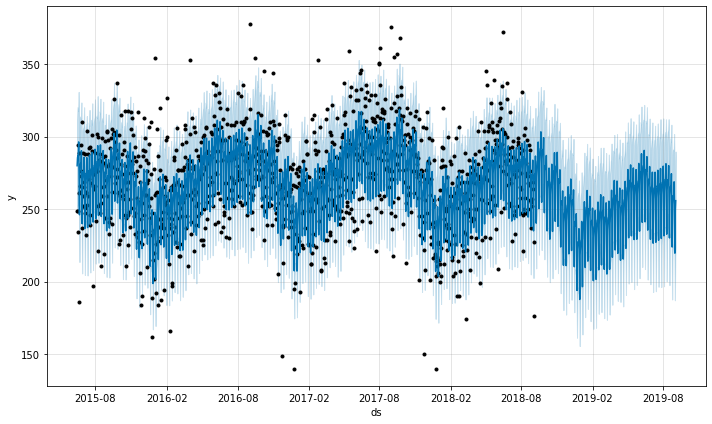

In [17]:
model.plot(forecasted);

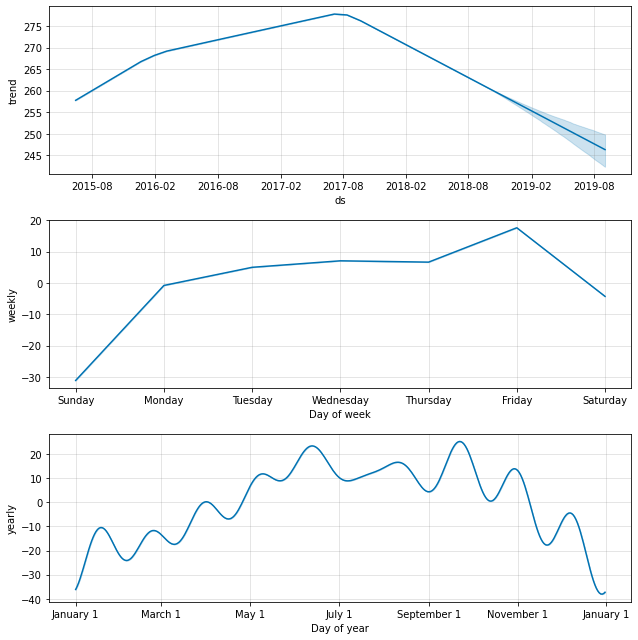

In [18]:
model.plot_components(forecasted);

# Train - Test Evaluation

In [40]:
results_df = pd.DataFrame(columns=['MAE', 'MAPE'])

## Data

In [23]:
tt_df = crime_df.resample(rule='D').sum()
tt_df['ds'] = p_df.index
tt_df = p_df.rename(columns={'Count':'y'})

train = tt_df[:1147]
test  = tt_df[1147:]

## Baseline

### Model

In [54]:
model = auto_arima(train['y'])

In [56]:
model

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### Forecast

In [66]:
keys = test['ds']
pred = model.predict(n_periods=30)
forecasted = pd.DataFrame({'ds':keys, 'yhat':pred})

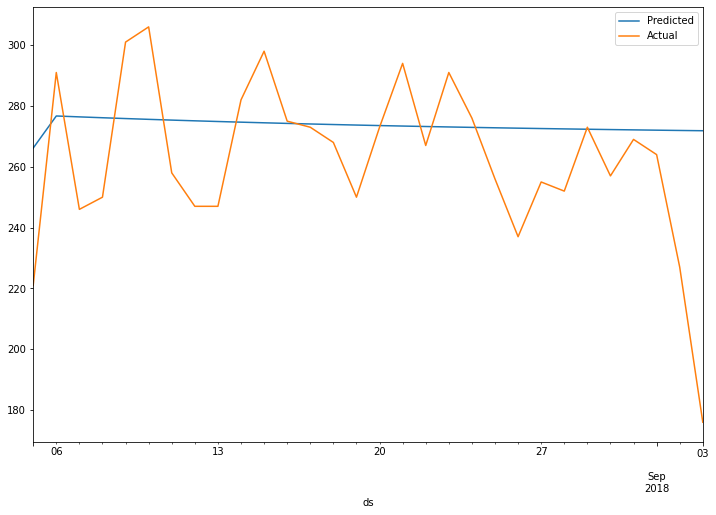

In [68]:
ax = forecasted.plot(x='ds', y='yhat', label='Predicted', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='Actual', legend=True, ax=ax);

### Error

In [71]:
pred = forecasted.iloc[-30:]['yhat']
actual = test['y']

In [72]:
mae = mean_absolute_error(actual, pred)
mape = mean_absolute_percentage_error(actual, pred)
results_df.loc['ARIMA'] = [mae, mape]

## Prophet

### Model

In [84]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Forecast

In [85]:
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)

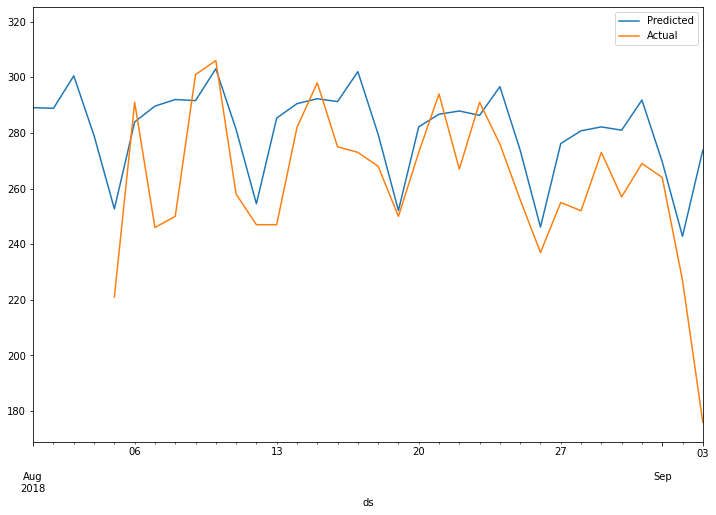

In [86]:
ax = forecasted.plot(x='ds', y='yhat', label='Predicted', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='Actual', legend=True, ax=ax, 
          xlim=('2018-08-01', '2018-09-03'));

### Error

In [87]:
pred = forecasted.iloc[-30:]['yhat']
actual = test['y']

In [88]:
mae = mean_absolute_error(actual, pred)
mape = mean_absolute_percentage_error(actual, pred)
results_df.loc['Prophet'] = [mae, mape]

## Comparison

In [89]:
results_df

,MAE,MAPE
Prophet,19.791884,0.082905
ARIMA,20.464302,0.085591


# Cross-Validation
* Measure forecast error using historical data
* Supports running cv in parallel (process / thread / dask)
* Helpful for hyperparameter tuning (Not all params)


![](https://facebook.github.io/prophet/static/diagnostics_files/diagnostics_4_0.png)

In [90]:
initial = f'730 days'
period  = f'365 days'
horizon = f'365 days'

cv_df = cross_validation(model, initial=initial, period=period, horizon=horizon)
cv_df

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-08-04 00:00:00 and 2017-08-04 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-08-05,294.922537,262.285117,325.980502,257,2017-08-04
1,2017-08-06,268.340887,235.160551,303.339050,248,2017-08-04
2,2017-08-07,300.586507,267.856652,330.398144,317,2017-08-04
3,2017-08-08,304.440211,273.586398,338.622277,290,2017-08-04
4,2017-08-09,306.826289,272.562930,338.621588,319,2017-08-04
...,...,...,...,...,...,...
360,2018-07-31,315.955899,283.271245,351.931583,275,2017-08-04
361,2018-08-01,318.408975,286.427634,349.270244,264,2017-08-04
362,2018-08-02,317.867044,285.421103,352.312955,282,2017-08-04
363,2018-08-03,328.606053,296.521210,360.592646,331,2017-08-04


In [91]:
performance_metrics(cv_df)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,792.965785,28.159648,22.382052,0.080005,0.058355,0.805556
1,37 days,764.030580,27.641103,21.881734,0.078164,0.058355,0.833333
2,38 days,755.994620,27.495356,21.626599,0.076888,0.057515,0.833333
3,39 days,761.309150,27.591831,21.766906,0.077572,0.058355,0.833333
4,40 days,759.732772,27.563250,21.707997,0.077265,0.058355,0.833333
...,...,...,...,...,...,...,...
325,361 days,1162.210528,34.091209,29.506317,0.110379,0.097888,0.611111
326,362 days,1241.404693,35.233573,30.727208,0.115135,0.099748,0.583333
327,363 days,1271.619066,35.659768,31.331930,0.117467,0.102055,0.555556
328,364 days,1257.841818,35.466066,30.776236,0.115508,0.102055,0.555556


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


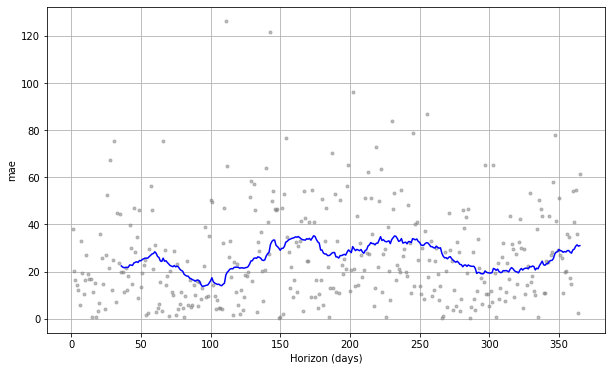

In [93]:
plot_cross_validation_metric(cv_df, metric='mae');

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


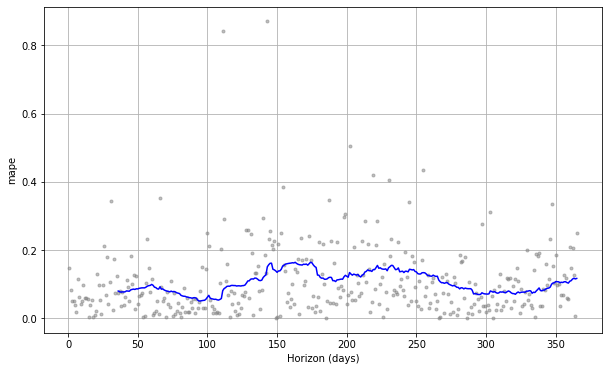

In [107]:
plot_cross_validation_metric(cv_df, metric='mape');

# Saturating
* Saturation / limits to growth prevent our model from growing or shrinking to absurd amounts
* We need to provide the model the carry capacity and floor

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


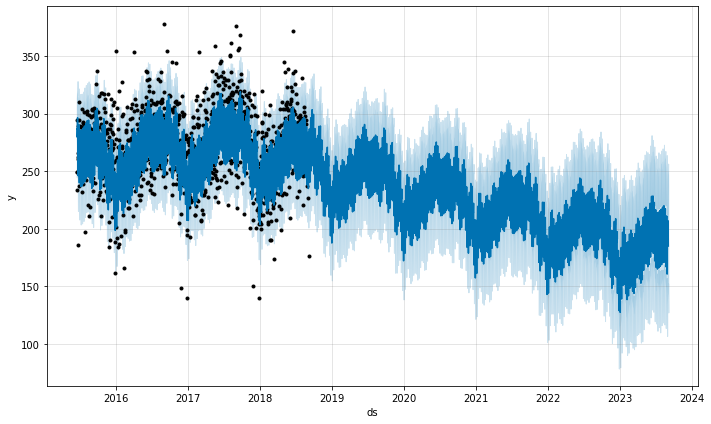

In [139]:
model = Prophet()
model.fit(p_df)
future = model.make_future_dataframe(periods=365 * 5, freq='D')
forecasted = model.predict(future)
model.plot(forecasted);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


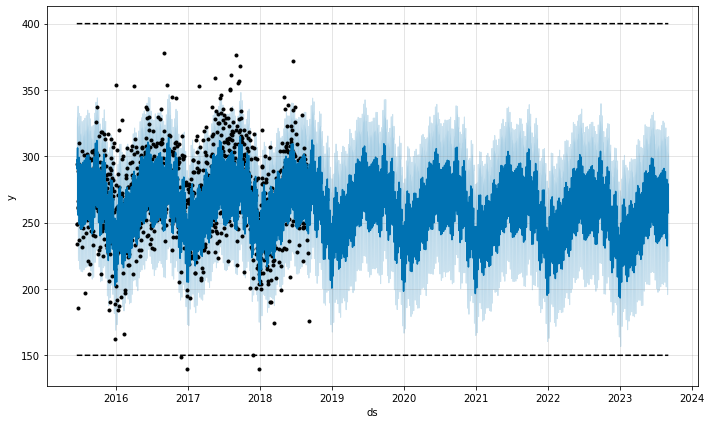

In [142]:
cap_df = p_df.copy()
cap_df['cap'] = 400
cap_df['floor'] = 150

model = Prophet(growth='logistic')
model.fit(cap_df)

future = model.make_future_dataframe(periods=365 * 5, freq='D')
future['cap'] = 400
future['floor'] = 150

forecasted = model.predict(future)
model.plot(forecasted);

# Holidays
* Has support for country holidays (holidays package)
* When added, they appear in the components breakout

In [97]:
christmas = ['2015-12-24', '2015-12-25', 
             '2016-12-24', '2016-12-25',
             '2017-12-24', '2017-12-25',
             '2018-12-24', '2018-12-25']
new_years = ['2015-12-31', '2016-01-01',
             '2016-12-31', '2017-01-01',
             '2017-12-31', '2018-01-01',
             '2018-12-31', '2019-01-01']
four_jul  = ['2015-07-04', '2016-07-04',
             '2017-07-04', '2018-07-04']
st_pat    = ['2015-03-17', '2016-03-17',
             '2017-03-17', '2018-03-17']

holidays = christmas + new_years + four_jul + st_pat
holidays_df = pd.DataFrame(holidays, columns=['ds'])
holidays_df['holiday'] = 'Holiday'
holidays_df['ds'] = pd.to_datetime(holidays_df.ds)
holidays_df

,ds,holiday
0,2015-12-24,Holiday
1,2015-12-25,Holiday
2,2016-12-24,Holiday
3,2016-12-25,Holiday
4,2017-12-24,Holiday
5,2017-12-25,Holiday
6,2018-12-24,Holiday
7,2018-12-25,Holiday
8,2015-12-31,Holiday
9,2016-01-01,Holiday


In [98]:
model = Prophet(holidays=holidays_df)
model.fit(p_df)
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


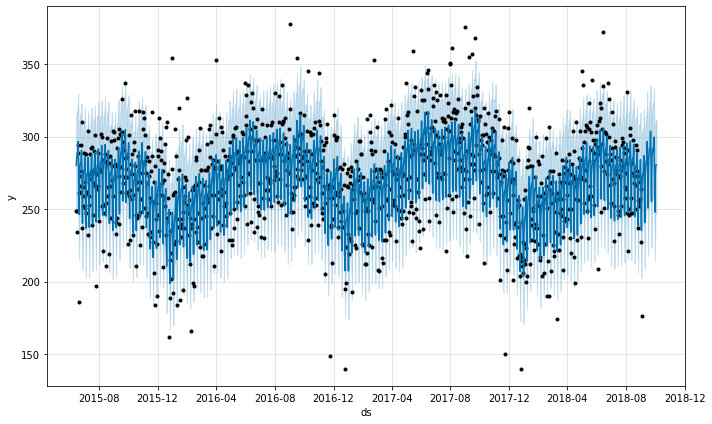

In [99]:
fig = model.plot(forecasted)

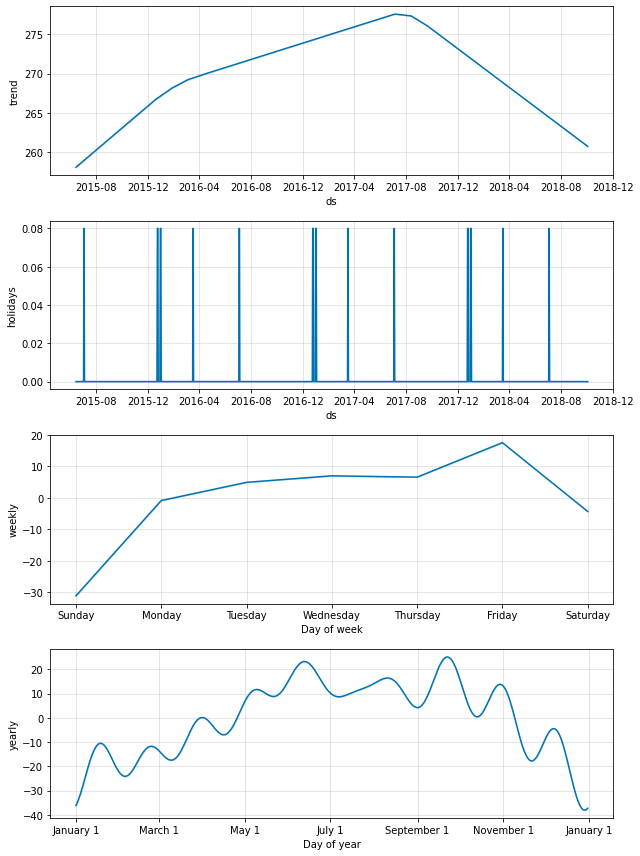

In [100]:
model.plot_components(forecasted);

# Trend Changes

## Automated

In [103]:
model = Prophet()
model.fit(p_df)
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


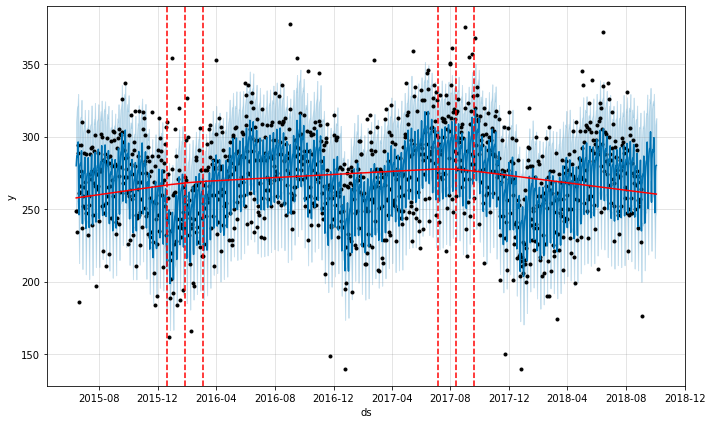

In [104]:
fig = model.plot(forecasted)
added = add_changepoints_to_plot(fig.gca(), model, forecasted)

## Manual

In [105]:
model = Prophet(changepoints=['2017-01-01'])
model.fit(p_df)
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


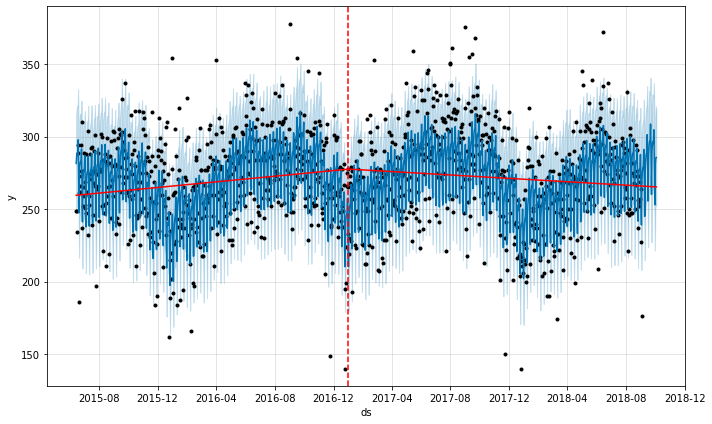

In [106]:
fig = model.plot(forecasted)
added = add_changepoints_to_plot(fig.gca(), model, forecasted)

# Seasonality
* Control of complexity comes from fourier terms
* More terms can fit complex series 
* More terms can be more apt to overfit

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


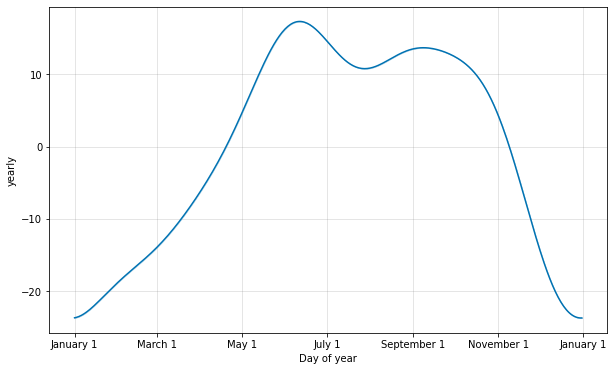

In [121]:
model = Prophet(yearly_seasonality=5)
model.fit(p_df)
plot_yearly(model);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


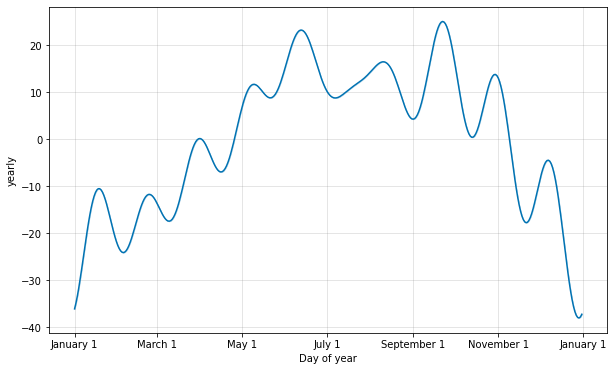

In [122]:
model = Prophet(yearly_seasonality=10)
model.fit(p_df)
plot_yearly(model);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


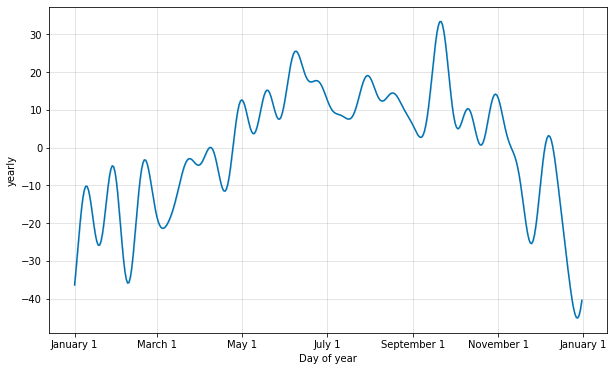

In [123]:
model = Prophet(yearly_seasonality=20)
model.fit(p_df)
plot_yearly(model);

# Uncertainty

## Trend

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


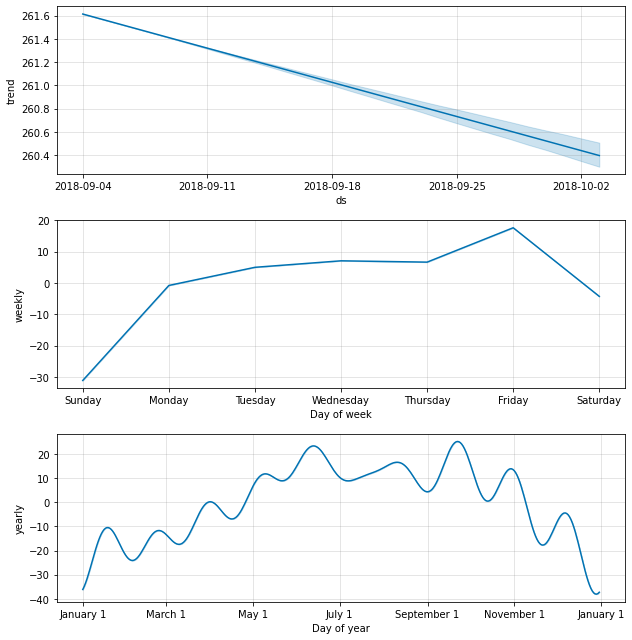

In [135]:
model = Prophet(interval_width=0.9)
model.fit(p_df)
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)
model.plot_components(forecasted[-30:], uncertainty=True);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


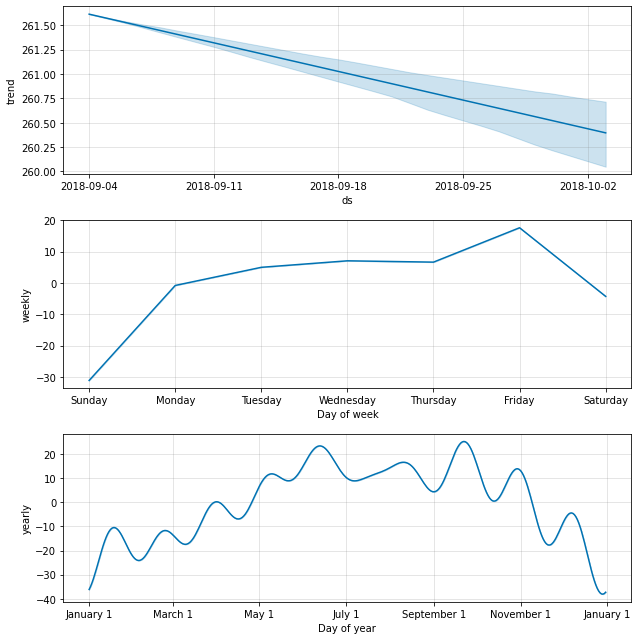

In [136]:
model = Prophet(interval_width=0.99)
model.fit(p_df)
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)
model.plot_components(forecasted[-30:], uncertainty=True);

## Seasonal

In [101]:
model = Prophet(mcmc_samples=300)
model.fit(p_df)
future = model.make_future_dataframe(periods=30, freq='D')
forecasted = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


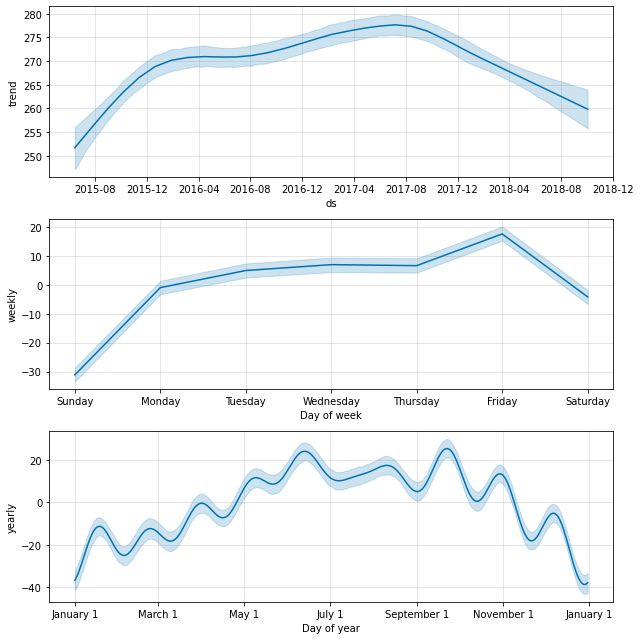

In [102]:
model.plot_components(forecasted);